In [1]:
import numpy as np
import random
import pandas as pd
from pylab import mpl, plt

import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [3]:
print(f"Using {device} device")

Using cuda device


In [31]:
# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states!
        out = self.fc(out[:, -1, :])
        # out.size() --> 100, 10
        return out

In [32]:
training_set = pd.read_csv('https://raw.githubusercontent.com/juff12/StockTradingModel/main/data/crypto/data/formatted/btcusd/btcusd_1_hour_data_formatted.csv')
training_set = training_set[['date','open','high','low','close','volume']]
#training_set = training_set.iloc[len(training_set)//3:]

# set the dates to datetiem
training_set['date'] = pd.to_datetime(training_set['date'])
training_set.set_index('date', inplace=True)

In [33]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54144 entries, 2017-12-31 19:00:00 to 2024-03-05 18:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    54144 non-null  float64
 1   high    54144 non-null  float64
 2   low     54144 non-null  float64
 3   close   54144 non-null  float64
 4   volume  54144 non-null  float64
dtypes: float64(5)
memory usage: 2.5 MB


In [34]:
training_set.head()

,open,high,low,close,volume
date,,,,,
2017-12-31 19:00:00,13769.00,14052.3,13500.01,13607.0,3039.529948
2017-12-31 20:00:00,13600.00,13885.5,13224.70,13280.0,2905.149259
2017-12-31 21:00:00,13280.00,13645.5,13214.00,13362.0,2235.304916
2017-12-31 22:00:00,13407.98,13898.9,13302.51,13398.0,2298.352474
2017-12-31 23:00:00,13393.00,13893.0,13262.00,13620.0,2047.258547


In [35]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

In [36]:
training_set[['open','high','low','close','volume']] = scaler.fit_transform(training_set[['open','high','low','close','volume']].values.reshape(-1,5))

In [37]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []

    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])

    data = np.array(data)

    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:-1]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:-1]

    return [x_train, y_train, x_test, y_test]

In [38]:
# try look back of 120 for 5 minute
#################################
################################
# try dropout

In [39]:
look_back = 60
x_train, y_train, x_test, y_test = load_data(training_set, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (43267, 59, 5)
y_train.shape =  (43267, 4)
x_test.shape =  (10817, 59, 5)
y_test.shape =  (10817, 4)


In [40]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [41]:
x_train = x_train.to(device)
x_test = x_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [42]:
input_dim = 5
hidden_dim = 32
num_layers = 3
output_dim = 4

In [43]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model = model.to(device)
loss_fn = torch.nn.MSELoss()
loss_fn = loss_fn.to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(5, 32, num_layers=3, batch_first=True)
  (fc): Linear(in_features=32, out_features=4, bias=True)
)
14
torch.Size([128, 5])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([4, 32])
torch.Size([4])


In [44]:
# Train model
#####################
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()

    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.05098792910575867
Epoch  20 MSE:  0.028040289878845215
Epoch  30 MSE:  0.0029188941698521376
Epoch  40 MSE:  0.0012233853340148926
Epoch  50 MSE:  0.0006372535135596991
Epoch  60 MSE:  0.00030432973289862275
Epoch  70 MSE:  0.0001792665134416893
Epoch  80 MSE:  0.00013796779967378825
Epoch  90 MSE:  0.00012173003779025748


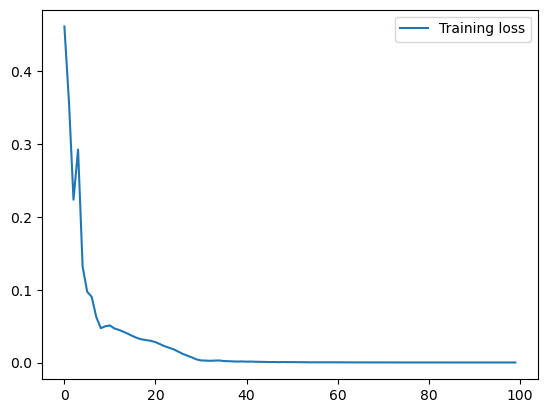

In [45]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [46]:
np.shape(y_train_pred)

torch.Size([43267, 4])

In [47]:
# make predictions
y_test_pred = model(x_test)

In [48]:
y_train_pred = y_train_pred.cpu().detach().numpy()
y_train = y_train.cpu().detach().numpy()
# resize the array
zeros_p = np.zeros((y_train_pred.shape[0],1))
zeros_t = np.zeros((y_train.shape[0],1))

y_train_pred = np.hstack((y_train_pred, zeros_p))
y_train = np.hstack((y_train, zeros_t))

In [49]:
y_test_pred = y_test_pred.cpu().detach().numpy()
y_test = y_test.cpu().detach().numpy()
# resize the array
zeros_p = np.zeros((y_test_pred.shape[0],1))
zeros_t = np.zeros((y_test.shape[0],1))
y_test_pred = np.hstack((y_test_pred, zeros_p))
y_test = np.hstack((y_test, zeros_t))

In [50]:
# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_train = scaler.inverse_transform(y_train)
y_test_pred = scaler.inverse_transform(y_test_pred)
y_test = scaler.inverse_transform(y_test)

In [51]:
# calculate root mean squared error
trainScore_high = math.sqrt(mean_squared_error(y_train[:,1], y_train_pred[:,1]))
print('Train Score (High): %.2f RMSE' % (trainScore_high))
trainScore_low = math.sqrt(mean_squared_error(y_train[:,2], y_train_pred[:,2]))
print('Train Score (Low): %.2f RMSE' % (trainScore_low))



#trainScore = math.sqrt(mean_squared_error(y_train[:,3], y_train_pred[:,3]))
#print('Train Score: %.2f RMSE' % (trainScore))
#testScore = math.sqrt(mean_squared_error(y_test[:,3], y_test_pred[:,3]))
#print('Test Score: %.2f RMSE' % (testScore))


testScore_high = math.sqrt(mean_squared_error(y_test[:,1], y_test_pred[:,1]))
print('Test Score (High): %.2f RMSE' % (testScore_high))
testScore_low = math.sqrt(mean_squared_error(y_test[:,2], y_test_pred[:,2]))
print('Test Score (Low): %.2f RMSE' % (testScore_low))

Train Score (High): 336.60 RMSE
Train Score (Low): 376.72 RMSE
Test Score (High): 311.71 RMSE
Test Score (Low): 270.61 RMSE


In [52]:
len(y_test)

10817

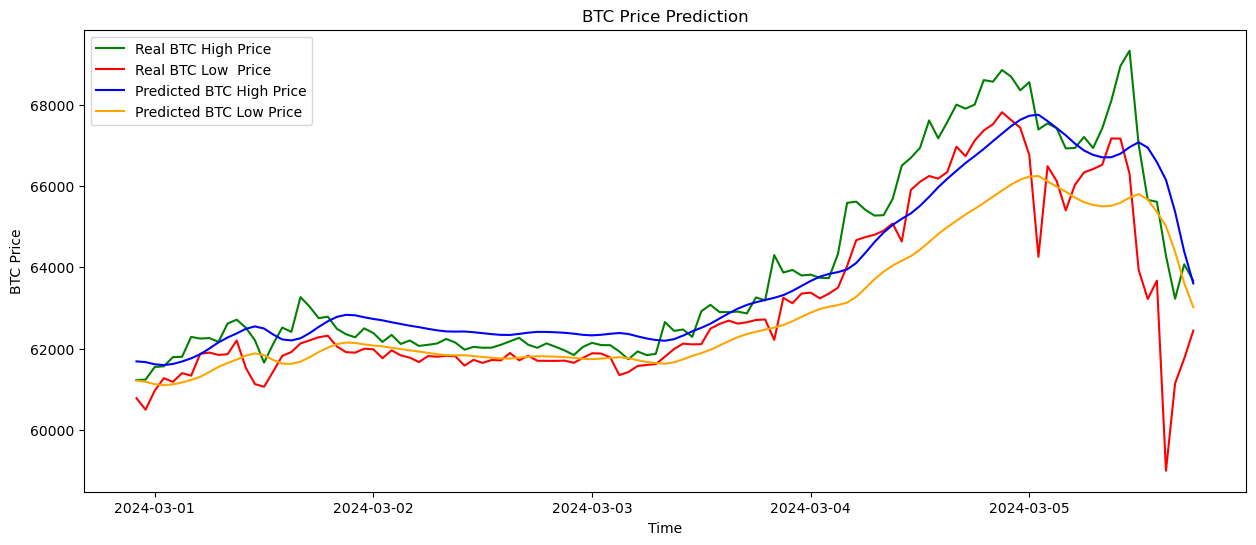

In [53]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()



window_start = 10700
window_end = len(y_test)
window = window_end - window_start
start = len(training_set)-len(y_test)+window_start

#axes.plot(training_set[start:start+window].index, y_test[window_start:window_end,1], color = 'purple', label = 'Real ETH Close Price')
#axes.plot(training_set[start:start+window].index, y_test_pred[window_start:window_end,3], color = 'red', label = 'Predicted ETH Close Price')

axes.plot(training_set[start:start+window].index, y_test[window_start:window_end,1], color = 'green', label = 'Real BTC High Price')
axes.plot(training_set[start:start+window].index, y_test[window_start:window_end,2], color = 'red', label = 'Real BTC Low  Price')

axes.plot(training_set[start:start+window].index, y_test_pred[window_start:window_end,1], color = 'blue', label = 'Predicted BTC High Price')
axes.plot(training_set[start:start+window].index, y_test_pred[window_start:window_end,2], color = 'orange', label = 'Predicted BTC Low Price')


#axes.xticks(np.arange(0,394,50))
plt.title('BTC Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend()
plt.savefig('btc_model_1hour_5in_4out_low_high_close_open_32batch_3layers_60_lookback_alldata.png')
plt.show()

In [28]:
torch.save(model.state_dict(), 'E:/models/btc_model_1hour_5in_4out_low_high_close_open_32batch_3layers_60_lookback_alldata.pth')